# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
from pymystem3 import Mystem
from collections import Counter
import numpy as np
pd.set_option('display.max_columns', 20)
m = Mystem()

In [2]:
data = pd.read_csv('/datasets/data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [4]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [5]:
data.loc[16335]

children                                   1
days_employed                  -18388.949901
dob_years                                 61
education                            среднее
education_id                               1
family_status                женат / замужем
family_status_id                           0
gender                                     F
income_type                        сотрудник
debt                                       0
total_income                   186178.934089
purpose             операции с недвижимостью
Name: 16335, dtype: object

In [6]:
print('Количество полных дубликатов в сете:', sum(data.duplicated()))

Количество полных дубликатов в сете: 54


**Вывод**

1. Дата-сет состоит из следующих столбцов: 
    + children — количество детей в семье
    + days_employed — общий трудовой стаж в днях
    + dob_years — возраст клиента в годах
    + education — уровень образования клиента
    + education_id — идентификатор уровня образования
    + family_status — семейное положение
    + family_status_id — идентификатор семейного положения
    + gender — пол клиента
    + income_type — тип занятости
    + debt — имел ли задолженность по возврату кредитов
    + total_income — ежемесячный доход
    + purpose — цель получения кредита
2. В столбцах `days_employed` и `total_income` наблюдаются пропуски. Количество пропусков идентично в обоих столбцах - можем предположить, что это связано
3. В столбце `days_employed` также наблюдаются отрицательные значения, что противоречит описанию данных в стобце - требуется нормализация. В этом же столбце мы наблюдаем избыточно большое значение. 
4. В столбце `education` наблюдается разное написание уровня образования. Вероятно, категории заемщиков по уровню образования дублируют друг друга.
5. Также в датасете наблюдаются 54 полных дубликата строк. Вероятно, при очистке данных, количество полных дубликатов строк может измениться

## Шаг 2. Предобработка данных

### Обработка пропусков

In [7]:
#проверим предположение о том, что пропуски в двух столбцах наблюдаются в одних и тех же строках
print('Количество строк с пропусками в столбце "days_employed":', len(data[data['days_employed'].isnull()]))
print('Количество строк с пропусками в столбце "total_income" для строк с пропусками в столбце "days_employed":', len(data[data['days_employed'].isnull()]['total_income'].isnull()))

Количество строк с пропусками в столбце "days_employed": 2174
Количество строк с пропусками в столбце "total_income" для строк с пропусками в столбце "days_employed": 2174


Идентичное количество пропусков означает, что эти данные не были введены, либо были потеряны одновременно. 
Мы можем заполнить пропуски в обоих столбцах следующими способами:
1. Столбец `days_employed` в целях снижения рисков путем завышения потенциального рейтинга клиента заполним нулями для пустых значений. Экстремумы исследуем отдельно. 
2. Столбец `total_income` можно запонить медианным уровнем дохода для конкретной категории заемщиков

In [8]:
data = data.fillna(0) #заполним пропуски в таблице нулями

In [9]:
#посчитаем количество отрицательных значений в таблице
print('Количество отрицательных значений в столбце "days_employed":', len(data[data['days_employed'] < 0]))

Количество отрицательных значений в столбце "days_employed": 15906


Наблюдаем примерно 3/4 наблюдений в таблице с отрицательным значением в столбце. Маловероятно, что на этапе ввода данных заемщик мог ввести отрицательное значение - вероятно он указывал даты, а далее внутри системы происходило какое-то вычисление - вероятно, в процессе этого вычисления была допущена ошибка. Добавим в датафрейм столбец, куда запишем примерный возраст начала трудовой деятельности (в процессе отрицательные значения превратим в положительные). Так мы сможем отбросить избыточно высокие значения. 

In [10]:
#убираем нули
data['days_employed'] = data['days_employed'].apply(lambda x: x if x >= 0 else x*(-1))
print('Количество отрицательных значений в столбце "days_employed":', len(data[data['days_employed'] < 0]))
display(data.head())

Количество отрицательных значений в столбце "days_employed": 0


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


А теперь прикинем "реалистичность" заявленных цифр, преобразовав дни в годы стажа и отняв этот стаж от заявленного возраста заемщика - так мы сразу увидим ошибки.

In [11]:
data['age_started_working'] = data['days_employed'].apply(lambda x: x / 365)
data['age_started_working'] = round(data['dob_years'] - data['age_started_working'], 1)

<AxesSubplot:>

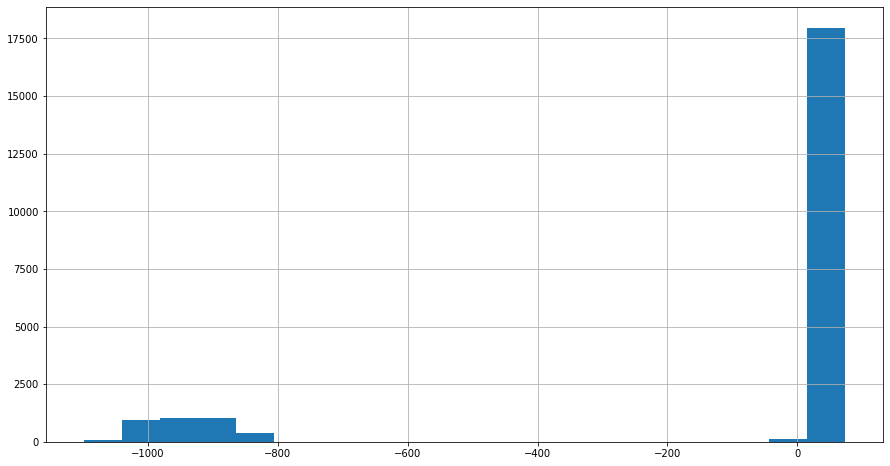

In [12]:
#построим гистограмму распределения значений
data['age_started_working'].hist(figsize=(15, 8), bins=20)

На гистограмме наблюдается относительная большая группа отрицательных значений (в некоторых корзинах около 1000 значений). Вероятно, в данных о количестве дней трудоустройства также есть некая системная ошибка и выбрасывать эти данные будет неправильно. Поближе посмотрим на данные:

In [13]:
data[data['age_started_working'] < 0].sort_values(by='days_employed')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_started_working
21179,2,108.967042,0,высшее,0,женат / замужем,0,M,компаньон,0,240702.007382,строительство жилой недвижимости,-0.3
6071,1,162.936952,0,среднее,1,гражданский брак,1,F,сотрудник,0,106956.800302,на покупку автомобиля,-0.4
16042,2,176.404487,0,среднее,1,женат / замужем,0,F,сотрудник,0,137563.630693,жилье,-0.5
11990,1,202.600508,0,СРЕДНЕЕ,1,женат / замужем,0,F,компаньон,1,167889.299943,на покупку автомобиля,-0.6
11289,1,223.709545,0,неоконченное высшее,2,гражданский брак,1,M,сотрудник,0,256070.541695,сыграть свадьбу,-0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7794,0,401663.850046,61,среднее,1,гражданский брак,1,F,пенсионер,0,48286.441362,свадьба,-1039.4
2156,0,401674.466633,60,среднее,1,женат / замужем,0,M,пенсионер,0,325395.724541,автомобили,-1040.5
7664,1,401675.093434,61,среднее,1,женат / замужем,0,F,пенсионер,0,126214.519212,операции с жильем,-1039.5
10006,0,401715.811749,69,высшее,0,Не женат / не замужем,4,F,пенсионер,0,57390.256908,получение образования,-1031.6


В датасете присутствуют данные о заемщиках без указанного возраста, что смазывает картину. Исключим такие строки:

In [14]:
data[(data['dob_years'] != 0) & (data['age_started_working'] < 0)].sort_values(by='days_employed')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_started_working
20444,0,328728.720605,72,среднее,1,вдовец / вдова,2,F,пенсионер,0,96519.339647,покупка жилья для семьи,-828.6
9328,2,328734.923996,41,высшее,0,женат / замужем,0,M,пенсионер,0,126997.497760,операции со своей недвижимостью,-859.6
17782,0,328771.341387,56,среднее,1,женат / замужем,0,F,пенсионер,0,68648.047062,операции с коммерческой недвижимостью,-844.7
14783,0,328795.726728,62,высшее,0,женат / замужем,0,F,пенсионер,0,79940.196752,на покупку своего автомобиля,-838.8
7229,1,328827.345667,32,среднее,1,гражданский брак,1,F,пенсионер,0,122162.965695,сыграть свадьбу,-868.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7794,0,401663.850046,61,среднее,1,гражданский брак,1,F,пенсионер,0,48286.441362,свадьба,-1039.4
2156,0,401674.466633,60,среднее,1,женат / замужем,0,M,пенсионер,0,325395.724541,автомобили,-1040.5
7664,1,401675.093434,61,среднее,1,женат / замужем,0,F,пенсионер,0,126214.519212,операции с жильем,-1039.5
10006,0,401715.811749,69,высшее,0,Не женат / не замужем,4,F,пенсионер,0,57390.256908,получение образования,-1031.6


Предположим, что максимально возможный трудовой стаж - 60 лет, что равно 21900 дню. Любые значения выше этой планки мы можем обработать в соответствии с определенной логикой - значения в таблице выглядят завышенными на два порядка, что мы исправим:

In [15]:
data['days_employed'] = data['days_employed'].apply(lambda x: x / 100 if x > (60*365) else x)
#и снова пересчитаем возраст начала трудовой деятельности
data['age_started_working'] = data['days_employed'].apply(lambda x: x / 365)
print('Количество записей, соответствующих условия из приведенной выше таблицы:', len(data[(data['dob_years'] != 0) & (data['age_started_working'] < 0)].sort_values(by='days_employed')))
del data['age_started_working']

Количество записей, соответствующих условия из приведенной выше таблицы: 0


In [16]:
#добавим в сет дополнительный срез для аналитики - общее количество трудового стажа
data['yrs_employed'] = round(data['days_employed'] / 365, 1)

А теперь проверим, стыкуется ли количество стажа с указанным возрастом:

In [17]:
data['started_working'] = data['dob_years'] - data['yrs_employed']
data[data['dob_years'] != 0].sort_values(by='started_working')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,yrs_employed,started_working
16335,1,18388.949901,61,среднее,1,женат / замужем,0,F,сотрудник,0,186178.934089,операции с недвижимостью,50.4,10.6
5708,0,13210.485012,47,среднее,1,женат / замужем,0,F,сотрудник,0,144845.875361,покупка недвижимости,36.2,10.8
397,0,12506.318296,46,среднее,1,женат / замужем,0,F,сотрудник,0,292843.287967,недвижимость,34.3,11.7
5959,0,10939.299825,42,среднее,1,женат / замужем,0,F,сотрудник,0,74840.802028,автомобиль,30.0,12.0
13531,0,9762.839918,39,среднее,1,женат / замужем,0,F,сотрудник,0,129855.627483,операции с коммерческой недвижимостью,26.7,12.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11548,0,0.000000,71,среднее,1,женат / замужем,0,M,пенсионер,0,0.000000,покупка жилой недвижимости,0.0,71.0
6537,0,0.000000,71,Среднее,1,гражданский брак,1,F,пенсионер,0,0.000000,на проведение свадьбы,0.0,71.0
10563,0,0.000000,72,Среднее,1,Не женат / не замужем,4,F,пенсионер,1,0.000000,приобретение автомобиля,0.0,72.0
13864,0,0.000000,72,среднее,1,женат / замужем,0,F,компаньон,0,0.000000,сделка с автомобилем,0.0,72.0


Наблюдаем странные значения (начало трудовой деятельности в 10-11 лет). Вероятно, такие данные не заслуживают полного доверия и следовало бы уточнить их происхождение у поставщика в реальных условиях, но так как мы такой возможностью не располагаем, такие значения можно будет не использовать впоследствии - по закону граждане могут начинать трудовую деятельность с 16 лет, поэтому посчитаем количество заемщиков с меньшим указанным возрастом:

In [18]:
#data[(data['dob_years'] != 0) & (data['started_working'] >= 16)].sort_values(by='started_working')
print('Количество потенциальных заемщиков, начавших трудовую деятельность ранее 16 лет:', len(data[data['started_working'] < 16]))

Количество потенциальных заемщиков, начавших трудовую деятельность ранее 16 лет: 191


In [19]:
#оставим в датасете только заслуживающие доверия записи
data = data[data['started_working'] >= 16].reset_index(drop=True)

Для заполнения пропусков в уровне дохода используем медианный уровень дохода группы, состоящей из нескольких признаков:
1. income_type
2. dob_years
3. education

Для этого потребуется:
1. Проверить значения в соответствующих столбцах и нормализовать их при необходимости
2. Сформировать категории по возрасту

In [20]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,yrs_employed,started_working
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,23.1,18.9
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,11.0,25.0
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,15.4,17.6
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,11.3,20.7
4,0,3402.660720,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,9.3,43.7


Наблюдаем разный регистр написания уровня образования, что фактически является дублями, но мы исправим это сейчас для корректного формирования групп и последующего расчета медианного дохода для заполнения пропусков.

In [21]:
data['education'] = data['education'].str.lower()
data['education'].value_counts()

среднее                15100
высшее                  5207
неоконченное высшее      741
начальное                280
ученая степень             6
Name: education, dtype: int64

Видим, что дублей в значениях нет. Также проверим тип дохода:

In [22]:
data['income_type'].value_counts()

сотрудник          11000
компаньон           5053
пенсионер           3834
госслужащий         1441
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

При помощи функции классифицируем значения по возрастным группам:

In [23]:
def age_classifier(row):
    age = row['dob_years']
    if age < 18:
        row['age_group'] = 'несовершеннолетние'
    elif 18 <= age <= 35:
        row['age_group'] = 'молодежь'
    elif 36 <= age <= 60:
        row['age_group'] = 'зрелые люди'
    elif age > 60 and row['gender'] == 'F':
        row['age_group'] = 'пенсионеры'
    elif age > 65 and row['gender'] == 'M':
        row['age_group'] = 'пенсионеры'
    else:
        row['age_group'] = 'зрелые люди'
    return row

In [24]:
data['age_group'] = ''
data = data.apply(age_classifier, axis=1)

In [25]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,yrs_employed,started_working,age_group
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,23.1,18.9,зрелые люди
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,11.0,25.0,зрелые люди
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,15.4,17.6,молодежь
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,11.3,20.7,молодежь
4,0,3402.660720,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,9.3,43.7,зрелые люди


In [26]:
#соберем детализированный датафрейм с медианным доходом по группам, сформированным из 3 признаков
median_income = data.groupby(['education', 'income_type', 'age_group'], as_index=False)['total_income'].median()
median_income = median_income.rename(columns={'total_income': 'median_income'})
#присоединим его к исходному датафрейму
data = data.merge(median_income, on=['education', 'age_group', 'income_type'], how='left')

In [27]:
def income_filler(row):
    salary = row['total_income']
    if salary == 0:
        row['total_income'] = row['median_income']
    return row

In [28]:
print('Количество потенциальных заемщиков с нулевым доходом ДО:', len(data[data['total_income'] == 0]))
data = data.apply(income_filler, axis=1)

Количество потенциальных заемщиков с нулевым доходом ДО: 2164


In [29]:
print('Количество потенциальных заемщиков с нулевым доходом ПОСЛЕ:', len(data[data['total_income'] == 0]))

Количество потенциальных заемщиков с нулевым доходом ПОСЛЕ: 2


Количество потенциальных заемщиком, для которых в референтных группах не был подобран медианный доход равно двум (вероятно, своему появлению группы обязаны этим необычным значениям). Для целей исследования таких клиентов можем исключить:

In [30]:
data = data[data['total_income'] > 0]
del data['median_income']
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,yrs_employed,started_working,age_group
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,23.1,18.9,зрелые люди
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,11.0,25.0,зрелые люди
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,15.4,17.6,молодежь
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,11.3,20.7,молодежь
4,0,3402.660720,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,9.3,43.7,зрелые люди


In [31]:
#посмотрим на данные после производенной обработки
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21332 entries, 0 to 21333
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21332 non-null  int64  
 1   days_employed     21332 non-null  float64
 2   dob_years         21332 non-null  int64  
 3   education         21332 non-null  object 
 4   education_id      21332 non-null  int64  
 5   family_status     21332 non-null  object 
 6   family_status_id  21332 non-null  int64  
 7   gender            21332 non-null  object 
 8   income_type       21332 non-null  object 
 9   debt              21332 non-null  int64  
 10  total_income      21332 non-null  float64
 11  purpose           21332 non-null  object 
 12  yrs_employed      21332 non-null  float64
 13  started_working   21332 non-null  float64
 14  age_group         21332 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 2.6+ MB


In [32]:
#теперь проверим корректность данных по числовым признакам
data.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income,yrs_employed,started_working
count,21332.000000,21332.000000,21332.000000,21332.000000,21332.000000,21332.000000,2.133200e+04,21332.000000,21332.000000
mean,0.538956,2295.241717,43.512704,0.817692,0.971686,0.081052,1.644249e+05,6.288168,37.224536
std,1.379590,2126.947825,12.251172,0.548095,1.419687,0.272921,9.826288e+04,5.827190,11.620147
min,-1.000000,0.000000,19.000000,0.000000,0.000000,0.000000,2.066726e+04,0.000000,16.000000
25%,0.000000,604.745199,33.000000,1.000000,0.000000,0.000000,1.065532e+05,1.700000,27.400000
50%,0.000000,1798.809701,43.000000,1.000000,0.000000,0.000000,1.428943e+05,4.900000,36.300000
75%,1.000000,3558.212227,53.000000,1.000000,1.000000,0.000000,1.970500e+05,9.700000,46.500000
max,20.000000,16119.687737,75.000000,4.000000,4.000000,1.000000,2.265604e+06,44.200000,73.000000


In [33]:
data['children'].value_counts()

 0     14014
 1      4784
 2      2035
 3       327
 20       75
-1        47
 4        41
 5         9
Name: children, dtype: int64

In [34]:
irrelevant_children_number_lenght = len(data[(data['children'] == -1) | (data['children'] == 20)])/len(data)
print(f'Доля записей с отрицательным или избыточно большим числом детей в сете {irrelevant_children_number_lenght:.2%}')

Доля записей с отрицательным или избыточно большим числом детей в сете 0.57%


В столбце с количеством детей две явных аномалии:
1. Отрицательно значение
2. Избыточно большое количество - 20 детей

Решение следующее:
1. У отрицательного значения изменим знак, предполагая, что это ошибка преобразования данных
2. Так как между 5 и 20 детьми нет значений, это наводит на мысль об ошибке ввода. Исправим 20 на 2 детей.

Эти варианты можно считать подходящими, так как общая доля таких записей в таблице невелика (0.57%), при этом эти же строки могут содержать потенциально ценную информацию для ответа на другие вопросы исследования. 

In [35]:
data['children'] = data['children'].apply(lambda x: x*(-1) if x < 0 else 2 if x == 20 else x)

In [36]:
#проверим
data['children'].value_counts()

0    14014
1     4831
2     2110
3      327
4       41
5        9
Name: children, dtype: int64

Проверим, нет ли ошибок в столбце с полом заемщика:

In [37]:
data['gender'].value_counts()

F      14089
M       7242
XNA        1
Name: gender, dtype: int64

In [38]:
#оставим в датасете записи, у которых нет ошибок в вводе пола
data = data[data['gender'] != 'XNA']

Проверим, нет ли ошибок в идентификаторе семейного статуса и уровня образования и непосредственно самом названии такого статуса и уровня образования:

In [39]:
display(data.groupby(['education'])['education_id'].mean())
print()
display(data.groupby(['family_status'])['family_status_id'].mean())

education
высшее                 0
начальное              3
неоконченное высшее    2
среднее                1
ученая степень         4
Name: education_id, dtype: int64

family_status
Не женат / не замужем    4
в разводе                3
вдовец / вдова           2
гражданский брак         1
женат / замужем          0
Name: family_status_id, dtype: int64

**Вывод**

Были произведены следующие действия: 

1. Удалены пропуски в количестве лет трудового стажа. Была произведена замена на нулевое значение, так как заполнение этого признака средним значение для группы могло бы повлиять на оценку кредитного потенциала клиента в сторону повышения риска (заемщику с нулевым трудовым стажем присвоено отличное от нуля значение, что повышает его оценку, но не отражает действительность, а значит повышает риск невозврата денежных средств
2. Уровень доходов был заполнен медианными значениями, полученных для групп очень низкого уровня (комбинация трех признаков: группа возраста, источник дохода, уровень образования
3. Для обозначенных выше целей также было выполнено преобразование строк в столбце с уровнем образования в нижний регистр для исключения дубликатов категорийной переменной и произведена категоризация по возрастным группам
4. Исправлены аномалии в столбце `children`
5. Из датасета исключена 1 запись с неверно записанным полом - так как данные обезличены, установить вручную, какой конкретно пол у данного заемщика - возможным не представляется, поэтому эту одну запись просто уберем из сета
6. Также произведена проверка корректных связок идентификаторов категорий семейного положения и уровня образования

### Замена типа данных

Оценим потребность столбцов датасета в замене данных:

In [40]:
display(data.info())
print()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21331 entries, 0 to 21333
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21331 non-null  int64  
 1   days_employed     21331 non-null  float64
 2   dob_years         21331 non-null  int64  
 3   education         21331 non-null  object 
 4   education_id      21331 non-null  int64  
 5   family_status     21331 non-null  object 
 6   family_status_id  21331 non-null  int64  
 7   gender            21331 non-null  object 
 8   income_type       21331 non-null  object 
 9   debt              21331 non-null  int64  
 10  total_income      21331 non-null  float64
 11  purpose           21331 non-null  object 
 12  yrs_employed      21331 non-null  float64
 13  started_working   21331 non-null  float64
 14  age_group         21331 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 2.6+ MB


None

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,yrs_employed,started_working,age_group
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,23.1,18.9,зрелые люди
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,11.0,25.0,зрелые люди
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,15.4,17.6,молодежь
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,11.3,20.7,молодежь
4,0,3402.660720,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,9.3,43.7,зрелые люди


Видим, что можно преобразовать следующие значения:
1. Столбец `days_employed` в целое число - вряд ли даже один знак после точки дает данным дополнительную ценность для результатов исследования
2. Столбец `total_income` мы могли бы округлить до двух знаков после точки, так как речь о деньгах, но для целей исследования опять же будет достаточно представления в виде целого числа
3. Добавленные столбцы `yrs_employed` и `started_working` также можем привести к целому числу - этого будет достаточно для стоящих перед ними целей 

In [41]:
#приводим значения в столбцах к цельночисленному типу
data[['days_employed', 'yrs_employed', 'started_working', 'total_income']] = data[['days_employed', 'yrs_employed', 'started_working', 'total_income']].astype('int')

In [42]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,yrs_employed,started_working,age_group
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,23,18,зрелые люди
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,11,25,зрелые люди
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,15,17,молодежь
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,11,20,молодежь
4,0,3402,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,9,43,зрелые люди


In [43]:
#посмотрим на результат
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21331 entries, 0 to 21333
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21331 non-null  int64 
 1   days_employed     21331 non-null  int64 
 2   dob_years         21331 non-null  int64 
 3   education         21331 non-null  object
 4   education_id      21331 non-null  int64 
 5   family_status     21331 non-null  object
 6   family_status_id  21331 non-null  int64 
 7   gender            21331 non-null  object
 8   income_type       21331 non-null  object
 9   debt              21331 non-null  int64 
 10  total_income      21331 non-null  int64 
 11  purpose           21331 non-null  object
 12  yrs_employed      21331 non-null  int64 
 13  started_working   21331 non-null  int64 
 14  age_group         21331 non-null  object
dtypes: int64(9), object(6)
memory usage: 2.6+ MB


Наблюдаем снижение количества различных типов данных до двух: целое число и строка. 

**Вывод**

Преобразование ряда столбцов из вещественного числа в целое позволило упростить визуальное восприятие данных в датасете без какого-либо потенциального негативного эффекта на результаты исследования. 

### Обработка дубликатов

Мы уже избавились от дубликатов в столбце с уровнем образования. Вероятно, проблема была в том, что данные на входе не были валидированы по регистру, что и сформировало несколько идентичных категорий, записанных символами в разных регистрах. Столбец с источником дохода также проверен на наличие дубликатов перед расчетом медианного уровня дохода в группах, поэтому:
1. Необходимо проверить столбец `family_status`
2. После очистки этого столбца от возможных дубликатов, отбросить из датасета строки полных дубликатов при их наличии

In [44]:
data['family_status'].value_counts()

женат / замужем          12271
гражданский брак          4143
Не женат / не замужем     2786
в разводе                 1178
вдовец / вдова             953
Name: family_status, dtype: int64

Дублирующие значения не наблюдаем. 

In [45]:
print('Количество полных дубликатов в датасете:', sum(data.duplicated()))

Количество полных дубликатов в датасете: 71


In [46]:
#убираем полные дубликаты из сета
data = data.drop_duplicates().reset_index(drop=True)

**Вывод**

1. В процессе удаления мы очищены варианты написания уровня образования, что позволило исключить дублирующие категории
2. Также была удалена 71 строка-дубликат из сета (количество полных дублей выросла после очистки значений в некоторых столбцах). Вероятная причина появления - ошибки в процессе извлечения данных, так как строки копируют друг друга полностью, включая не "строгие" поля (категория займа)

### Лемматизация

При помощи библиотеки для лемматизации, цикла и списка "шумовых" слов составим словарь с наиболее популярными "целями" займа:

In [47]:
lemmas = []
for client in data['purpose']:
    suspended_words = ['покупка', 'свой', 'высокий', 'получение', 'коммерческий', 'жилой', 'заниматься', 'дополнительный', 'проведение', 'сыграть', 'сдача', 'собственный', 'подержанный', 'подержать', 'приобретение', 'профильный']
    l_words = m.lemmatize(client)
    for word in l_words:
        if len(word) > 3 and word not in suspended_words:
            lemmas.append(word)

In [48]:
#соберем словарик из лемм, в котором видны популярные цели
#данные из него же используем для отсева нерелеватных слов на предыдущем шаге
lemmas_freq = Counter(lemmas)
print(lemmas_freq)

Counter({'недвижимость': 6293, 'жилье': 4415, 'автомобиль': 4276, 'образование': 3972, 'операция': 2583, 'свадьба': 2304, 'строительство': 1866, 'сделка': 938, 'семья': 634, 'ремонт': 603})


При помощи функции используем результат лемматизации и добавим в кажду строку датафрейма "реальную" цель получения кредита. Эту информацию можно использовать для категоризации. 

In [49]:
def purpose_detector(row):
    for word in m.lemmatize(row['purpose']):
        for key, value in lemmas_freq.items():
            if word == key:
                row['purpose_category'] = key
    return row

In [50]:
data['purpose_category'] = ''
data = data.apply(purpose_detector, axis=1)

In [51]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,yrs_employed,started_working,age_group,purpose_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,23,18,зрелые люди,жилье
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,11,25,зрелые люди,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,15,17,молодежь,жилье
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,11,20,молодежь,образование
4,0,3402,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,9,43,зрелые люди,свадьба


In [52]:
#проверим столбцы на пропуски - видим, что в новом столбце пропусков нет
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
yrs_employed        0
started_working     0
age_group           0
purpose_category    0
dtype: int64

**Вывод**

При помощи лемматизации мы смогли преобразовать произвольную строку, использованную заемщиком для описания цели получения кредита, в конкретную цель, которую можно использовать для категоризации данных. 

### Категоризация данных

На шагах выше уже была произведена категоризация записей по группе возраста и цели получения кредита. Ниже приведен пример, который позволяет используя только результаты категоризации получить интересные инсайты на базе имеющихся данных.

In [53]:
data.groupby(['age_group', 'purpose_category']).agg({'days_employed': 'count', 'debt': 'mean', 'yrs_employed': 'mean'})

days_employed      debt  yrs_employed
age_group   purpose_category                                       
зрелые люди автомобиль                 2615  0.083365      6.786616
            жилье                      2252  0.059503      6.726909
            недвижимость               3867  0.069046      6.886475
            образование                2399  0.081701      6.588995
            свадьба                    1388  0.079971      6.935879
            семья                       391  0.071611      6.365729
молодежь    автомобиль                 1285  0.126070      3.395331
            жилье                      1221  0.090090      3.375921
            недвижимость               1913  0.096707      3.231573
            образование                1227  0.127954      3.537082
            свадьба                     724  0.091160      3.382597
            семья                       182  0.087912      3.434066
пенсионеры  автомобиль                  376  0.047872      8.638298
            жилье                       308  0.055195      8.743506
            недвижимость                513  0.038986      8.664717
            образование                 346  0.046243      8.921965
            свадьба                     192  0.036458      9.635417
            семья                        61  0.016393     10.213115

Для ответа на вопрос о влиянии уровня дохода на вероятность возврата кредита нам потребуется также категоризация по доходу - для этого воспользуемся методом .cut, который нарежет данные на группы и результатом заполним дополнительный столбец. 

In [54]:
data['income_category'] = pd.cut(data['total_income'], 
                                 bins=[0, 50000, 100000, 150000, 200000, 250000, np.inf], 
                                 labels=['До 50K', '50K-100K', '100K-150K', '150K-200K','200K-250K', 'Свыше 250K'])

In [55]:
#посмотрим на пример полученной категоризации
data.groupby(['income_category']).agg({'total_income': ['count', 'median']})

total_income          
                       count    median
income_category                       
До 50K                   368   43159.5
50K-100K                4056   81309.5
100K-150K               7330  126461.5
150K-200K               4489  170988.0
200K-250K               2225  221461.0
Свыше 250K              2792  305883.0

**Вывод**

1. Были выделены две категории: группа по возрасту и цели получения кредита
2. Также добавлена категоризация по уровню дохода

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [56]:
data.groupby(['children']).agg({'debt': ['count', 'mean']})

debt          
          count      mean
children                 
0         13955  0.075672
1          4821  0.091682
2          2107  0.094922
3           327  0.082569
4            41  0.097561
5             9  0.000000

**Вывод**

1. Наблюдаем наибольшее количество наблюдений в группе с 0 детей - 7.6%. В этой же группе самый низкий процент имеющих задолженность.
2. При увеличении количества детей наблюдаем колебания доли от 8.3% до 9.8%, что все равно выше группы без детей
3. В группе с 5 детьми доля нулевая, но учитывая малое количество наблюдений, можем пренебречь этой группой

Таким образом, из предоставленных данных следует, что количество детей скорее отрицательно влияет на вероятность возврата кредита в срок, но в целом колебания небольшие.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [57]:
data.groupby(['family_status']).agg({'debt': ['count', 'mean']})

debt          
                       count      mean
family_status                         
Не женат / не замужем   2783  0.098096
в разводе               1178  0.070458
вдовец / вдова           952  0.065126
гражданский брак        4117  0.093758
женат / замужем        12230  0.075634

**Вывод**

1. В целом, можем наблюдать, что потенциальные заемщики, находящиеся в данный момент в браке, либо находившиеся в нем в прошлом (вдовы/вдовцы и разведенные) имеют меньшую долю просрочек (от 6.5% до 7.6%)
2. Холостые, либо находящиеся в гражданском браке показывают более высокую долю просрочки (9.8% и 9.4% соответственно)

Это позволяе нам предположить, что женатые сейчас или в прошлом в целом более надежные заемщики, чем холостые, либо находящиеся в гражданском браке. 

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [58]:
data.groupby(['income_category']).agg({'debt': ['count', 'mean']})

debt          
                count      mean
income_category                
До 50K            368  0.059783
50K-100K         4056  0.081361
100K-150K        7330  0.087449
150K-200K        4489  0.084429
200K-250K        2225  0.073708
Свыше 250K       2792  0.069126

**Вывод**

1. Наиболее многочисленная группа по уровню дохода - 100-150 тысяч. В этой же группе наблюдается самый высокий процент должников - 8.8%
2. Однако с ростом уровня дохода доля должников постепенно снижается: 8.4%, 7.4%, 6.9%

Таким образом, мы можем полагать, что более высокий уровень дохода означает более высокую вероятность возврата денежных средств вовремя

- Как разные цели кредита влияют на его возврат в срок?

In [59]:
data.groupby(['purpose_category']).agg({'debt': ['count', 'mean']})

debt          
                 count      mean
purpose_category                
автомобиль        4276  0.093078
жилье             3781  0.069029
недвижимость      6293  0.075004
образование       3972  0.092900
свадьба           2304  0.079861
семья              634  0.070978

**Вывод**

1. В группах "автомобиль" и "образование" наблюдается самый высокий процент должников. Можем предположить, что риск лишиться автомобиля или образование (которое отобрать в принципе невозможно) слабо дисциплинирует людей, поэтому мы и наблюдаем 9.3% дожников в обеих группах
2. Самая низкая доля должников в группах "жилье" и "семья" - 6.9% и 7.1% соответственно 

На основании приведенных данных можем сделать вывод о влиянии цели кредита на вероятность его возврата вовремя. Более "фундаментальные" категории сильнее дисциплинируют заемщиков. 

## Шаг 4. Общий вывод

1. Была произведена очистика данных и удаление дубликатов:
    + В данных были обнаружены дубликаты категорий по уровню образования - проблема в разном регистре записи категории. Точно определить причину возникновения ошибки проблематично, но вероятно она где-то в процессе внесения данных в систему. Возможно использовались разные источники ввода. Валидацию входных данных можно проводить уже на этапе сбора
    + Также зафиксировано порядка 70 строк полных дубликатов (при этом их количество выросло с примерно 55 до 70 после очистки дублей в столбце с категориями по уровню образования). Стоит уделить внимание процессу проверки введенной информации, так как уже в процессе сбора на уровне БД стоит иметь защитный механизм.
    + В данных наблюдались два типа ошибка в данных с количеством отработанных дней (рекомендуется уделить особое внимание проверке заполнения данного столбца):
        - Часть значений была отрицательной. Не стоит исключать проблему ввода данных, но наиболее вероятно, что более 15 тысяч таких значений появились из-за ошибки на каком-то из этапов промежуточной обработки данных. Эта проблема была устранена преобразованием отрицательных значений в положительные.
        - Часть значений была неоправданно завышенной.
    + В столбце с уровнем дохода наблюдался множество пропусков. Оно было скорректировано путем заполнения медианным значением для групп по возрасту и источнику дохода. Рекомендуется записывать и хранить в БД только данные о заемщиках с указанным уровнем дохода
    + Также было выявлено, что в соответствии с указанными в таблице данными, часть заемщиков начала трудовую деятельность ранее законно установленного порога. Так как такие данные могут внести ошибки на этапе ответов на поставленные вопросы, было принято решение эту информацию исключить из анализа
2. Для ответа на поставленные перед исследованием вопросы была проведена категоризация значений в трех разрезах:
    + Группа по возрасту
    + Группа по "реальной" цели получения кредита
    + Группа по уровню дохода
3. Установлено:
    + Наличие детей скорее снижает вероятность возврата кредита в срок. При этом их количество влияет на долю должников в группах несущественно
    + Наличие супрага в текущий момент, либо его наличие в прошлом (развод/утеря супруга) говорит в пользу более высокой вероятности возврата кредита в срок
    + В группах заемщиков с более высоким уровнем дохода вероятность возврата кредита выше. При этом, при росте дохода наблюдается снижение доли должников 
    + Более "фундаментальные" категории займа (недвижимость, семья) показывают меньший процент должников. Наиболее "опасные" категории: автомобиль и образование

In [60]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,yrs_employed,started_working,age_group,purpose_category,income_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,23,18,зрелые люди,жилье,Свыше 250K
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,11,25,зрелые люди,автомобиль,100K-150K
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,15,17,молодежь,жилье,100K-150K
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,11,20,молодежь,образование,Свыше 250K
4,0,3402,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,9,43,зрелые люди,свадьба,150K-200K


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.